# Import Required Libraries
This cell imports essential libraries for data manipulation, model training, and evaluation.

In [1]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load Data
This cell pulls the latest data using DVC, constructs the data path, and loads the insurance dataset into a pandas DataFrame.

In [2]:
!dvc pull
notebook_dir = os.getcwd()
data_path = os.path.join(notebook_dir, "..", "data", "MachineLearningRating_v3.txt")

df = pd.read_csv(data_path, delimiter="|")

Everything is up to date.


C:\Users\Bisrat\AppData\Local\Temp\ipykernel_14708\825271066.py:5: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, delimiter="|")


# Preprocess Data for Severity Modeling
This cell filters the dataset to only include rows with claims, defines features and target, identifies categorical and numeric columns, applies preprocessing (including one-hot encoding), and splits the data into training and test sets.

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Filter to only rows where claims > 0
df_severity = df[df['TotalClaims'] > 0].copy()

# Define target and features
target = 'TotalClaims'
features = [col for col in df_severity.columns if col not in ['TotalClaims', 'CalculatedPremiumPerTerm', 'ClaimOccured']]

X = df_severity[features]
y = df_severity[target]

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Convert all categorical columns to string type to avoid mixed types
X[categorical_cols] = X[categorical_cols].astype(str)

# Set up preprocessing (same as training)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Fit and transform
X_processed = preprocessor.fit_transform(X)

# Split into train and test
X_train_severity, X_test_severity, y_train_severity, y_test_severity = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

C:\Users\Bisrat\AppData\Local\Temp\ipykernel_14708\3363105956.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_cols] = X[categorical_cols].astype(str)


# Import SHAP and Matplotlib
This cell imports SHAP for model explainability and Matplotlib for visualization.

In [4]:
import shap
import matplotlib.pyplot as plt


c:\Users\Bisrat\Desktop\KAIM\insurance_risk_analytics\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Trained Model
This cell loads the previously trained and saved model for severity prediction using joblib.

In [5]:
import joblib

# Load the saved model
xgb_model = joblib.load('../models/xgb_severity_model.pkl')


# Generate SHAP Values
This cell creates a SHAP explainer for the loaded model and computes SHAP values for the test set.

In [6]:
import xgboost as xgb

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_severity) 


# SHAP Summary Plot
This cell visualizes the global feature importance using a SHAP summary plot.

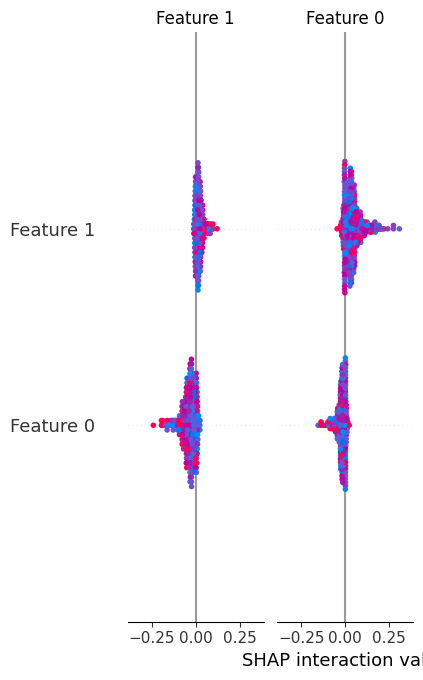

In [7]:
shap.summary_plot(shap_values, X_test_severity)

# SHAP Dependence Plot for a Feature
This cell generates a SHAP dependence plot for the "RegistrationYear" feature to show its effect on model predictions.

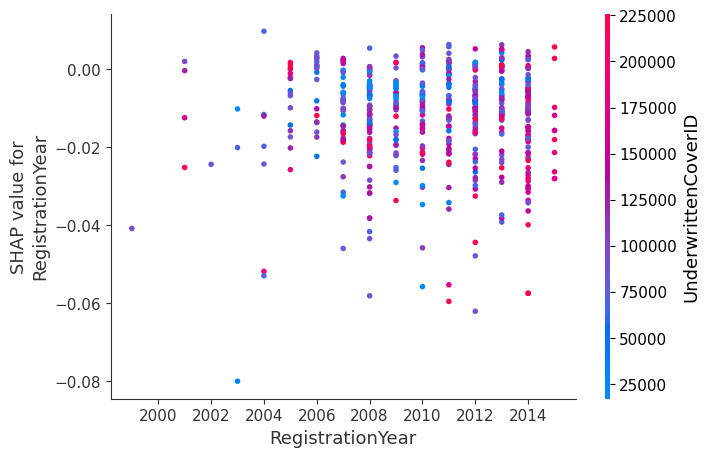

In [11]:
# Get feature names after transformation
feature_names = (
	numeric_cols +
	list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
)

feature_to_plot = "RegistrationYear"
feature_index = feature_names.index(feature_to_plot)

shap_values_for_plot = shap_values.values
if shap_values_for_plot.ndim == 3:
	shap_values_for_plot = shap_values_for_plot[:, :, 0]

# Plot SHAP dependence for "RegistrationYear"
shap.dependence_plot(feature_index, shap_values_for_plot, X_test_severity, feature_names=feature_names)